In [110]:
from __future__ import annotations
import jax
import jax.numpy as jnp

import pyhf
pyhf.set_backend("jax", default=True)

def make_model(pars: jnp.array, bins=2) -> pyhf.Model:
    bounded_pars_upper = jnp.where(pars > 10.0, 10.0, pars)
    bounded_pars = jnp.where(bounded_pars_upper < -10.0, -10.0, bounded_pars_upper)
    if bins == 2:
        u1, d1 = bounded_pars
        u = jnp.array([u1, -u1])
        d = jnp.array([d1, -d1])

        sig = jnp.array([5, 11])
        nominal = jnp.array([50, 50])
        up = jnp.array([50, 50]) + u
        down = jnp.array([50, 50]) + d

    elif bins == 3:
        u1, u2, d1, d2 = bounded_pars
        u = jnp.array([u1, u2, -u1 - u2])
        d = jnp.array([d1, d2, -d1 - d2])

        sig = jnp.array([2, 5, 10])
        nominal = jnp.array([50, 50, 50])
        up = jnp.array([50, 50, 50]) + u
        down = jnp.array([50, 50, 50]) + d

    m = {
        "channels": [
            {
                "name": "singlechannel",
                "samples": [
                    {
                        "name": "signal",
                        "data": sig,
                        "modifiers": [
                            {"name": "mu", "type": "normfactor", "data": None}
                        ],
                    },
                    {
                        "name": "background",
                        "data": nominal,
                        "modifiers": [
                            {
                                "name": "bkguncrt",
                                "type": "histosys",
                                "data": {"hi_data": up, "lo_data": down},
                            }
                        ],
                    },
                ],
            }
        ]
    }
    return pyhf.Model(m, validate=False), [sig,nominal,up,down]


def make_model2(pars: jnp.array, bins=2) -> pyhf.Model:
    bounded_pars_upper = jnp.where(pars > 10.0, 10.0, pars)
    bounded_pars = jnp.where(bounded_pars_upper < -10.0, -10.0, bounded_pars_upper)
    if bins == 2:
        u1, d1 = bounded_pars
        u = jnp.array([u1, -u1])
        d = jnp.array([d1, -d1])

        sig = jnp.array([5, 21])
        nominal = jnp.array([50, 50])
        up = jnp.array([50, 50]) + u
        down = jnp.array([50, 50]) + d

    m = {
        "channels": [
            {
                "name": "singlechannel",
                "samples": [
                    {
                        "name": "signal",
                        "data": sig,
                        "modifiers": [
                            {"name": "mu", "type": "normfactor", "data": None}
                        ],
                    },
                    {
                        "name": "background",
                        "data": nominal,
                        "modifiers": [
                            {
                                "name": "bkguncrt",
                                "type": "histosys",
                                "data": {"hi_data": up, "lo_data": down},
                            }
                        ],
                    },
                ],
            }
        ]
    }
    return pyhf.Model(m, validate=False)

In [ ]:
def model_uncor(pars)
    bounded_pars_upper = jnp.where(pars > 10.0, 10.0, pars)
    bounded_pars = jnp.where(bounded_pars_upper < -10.0, -10.0, bounded_pars_upper)
    signal = jnp.array([5, 21])
    bkg = jnp.array([50, 50])
    
    spec = {
        'channels': [
            {
                'name': 'singlechannel',
                'samples': [
                    {
                        'name': 'signal',
                        'data': signal,
                        'modifiers': [
                            {'name': 'mu', 'type': 'normfactor', 'data': None}
                        ],
                    },
                    {
                        'name': 'background',
                        'data': bkg,
                        'modifiers': [
                            {
                                'name': 'uncorr_bkguncrt',
                                'type': 'shapesys',
                                'data': pars,
                            }
                        ],
                    },
                ],
            }
        ]
    }
    return pyhf.Model(spec, validate=False)

In [111]:
import neos
import relaxed


def metrics(pars):
    model, yields = make_model(pars)
    lr=1e-3
    CLs = neos.losses.cls_value(model, lr)
    p0 = neos.losses.discovery_significance(model, lr)
    poi_uncert = neos.losses.poi_uncert(model)
    gaussianity = relaxed.metrics.gaussianity(model, jnp.array([1.,0.]), model.expected_data(jnp.array([1.,0.])), jax.random.PRNGKey(0), n_samples=1000)
    asimov = relaxed.metrics.asimov_sig(yields[0], yields[1])
    return dict(CLs=CLs, p0=p0, poi_uncert=poi_uncert, gaussianity=gaussianity, asimov=asimov)

import numpy as np

dense = 100
num_up, num_down = dense, dense

up_grid = np.linspace(-10.5, 9.5, num_up)
down_grid = np.linspace(-10, 10, num_down)

uv, dv = np.meshgrid(up_grid, down_grid)
grid = np.vstack([uv.ravel(), dv.ravel()]).T
mets = jax.vmap(metrics)(grid)

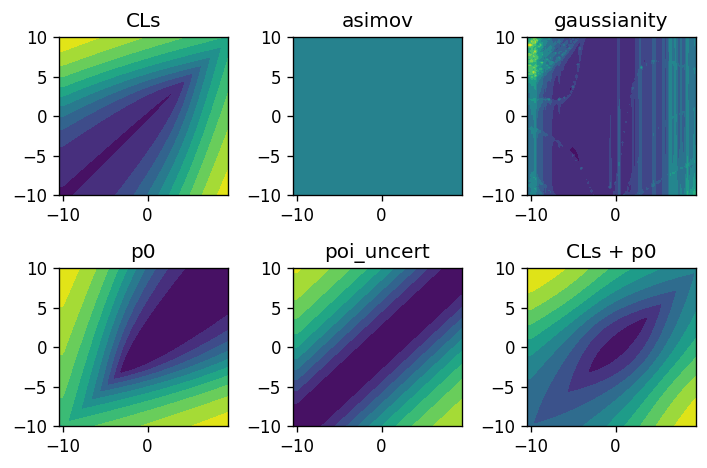

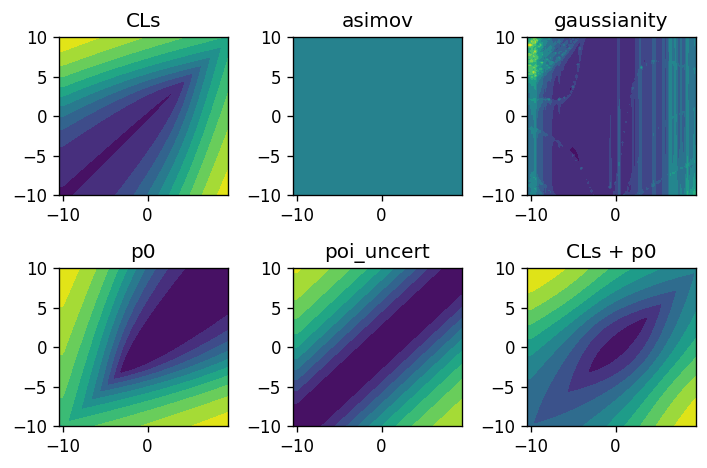

In [113]:
from plothelp import autogrid
from matplotlib import colors
def plot(dct):
    ax, (label, data), i = list(dct.values())
    ax.contourf(up_grid, down_grid, data.reshape(dense,dense), levels=10)#,norm=colors.LogNorm())
    ax.set_title(label)
    # ax.set_x


autogrid(
    list(mets.items())+[['CLs + p0', mets["CLs"]+mets["p0"]]],
    plot,
)

In [91]:
jax.vmap(metrics)(jnp.array([jnp.array([0.,0.]), jnp.array([-10,-10])]))

{'CLs': DeviceArray([0.10795565, 0.10795565], dtype=float64),
 'p0': DeviceArray([0.04881237, 0.04881237], dtype=float64),
 'poi_uncert': DeviceArray([0.64042697, 0.64042697], dtype=float64)}

In [94]:
grid[jnp.argmin(mets["CLs"]+mets["p0"])]

array([-10.5, -10. ])

In [49]:
import jaxopt
import optax

def loss(pars):
    mets = metrics(pars)
    return mets["CLs"] + mets["p0"]
solver = jaxopt.OptaxSolver(loss, optax.adam(1e-1), maxiter=100, jit=False)
solver.run(jnp.array([5.,-10.]))

KeyboardInterrupt: 

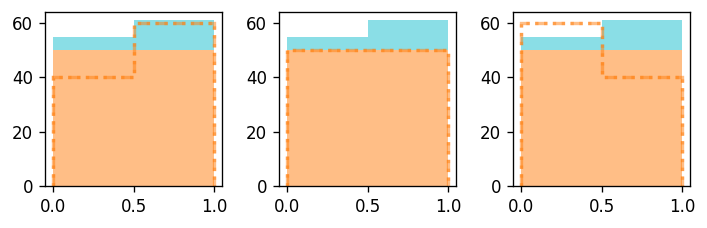

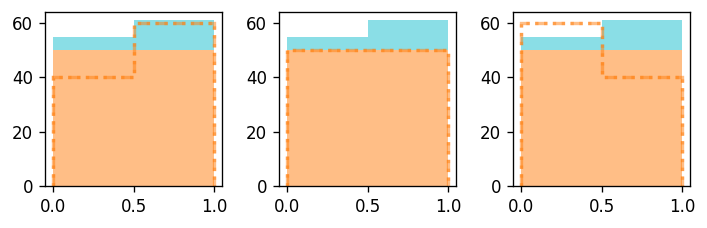

In [88]:
def model(u1, d1):
    u = jnp.array([u1, -u1])
    d = jnp.array([d1, -d1])

    sig = jnp.array([5, 11])
    nominal = jnp.array([50, 50])
    up = jnp.array([50, 50]) + u
    down = jnp.array([50, 50]) + d

    return pyhf.simplemodels.correlated_background(sig.tolist(), nominal.tolist(), up.tolist(), down.tolist()), [sig.tolist(), nominal.tolist(), up.tolist(), down.tolist()] 

grd = np.linspace(0, 50, 100)
xx, yy = np.meshgrid(grd, grd)
flat_grid = np.vstack([xx.ravel(), yy.ravel()]).T
def plot_lhood(dct):
    ax, (m, yields), i = list(dct.values())
    data = [50, 50] + m.config.auxdata
    pdf = jax.vmap(m.logpdf, in_axes=(0, None))(flat_grid, data)
    # ax.contourf(xx, yy, pdf.reshape(100,100), levels=10)
    binning = np.linspace(0,1,len(yields[0])+1)
    ax.stairs(yields[1], binning, label="bkg_nominal", alpha=0.5, color='C1', fill=True)
    ax.stairs(np.array(yields[1])+np.array(yields[0]), binning, label="sig", alpha=0.5, color='C9', fill=True, baseline=yields[1])

    ax.stairs(yields[2], binning, label="bkg_up", alpha=0.5, fill=None, edgecolor='C1', linewidth=2, linestyle="dotted")
    ax.stairs(yields[3], binning, label="bkg_down", alpha=0.5, fill=None, edgecolor='C1', linewidth=2, linestyle="dashed")


autogrid(
    [model(i,i) for i in [-10,0,10]],
    plot_lhood,
)

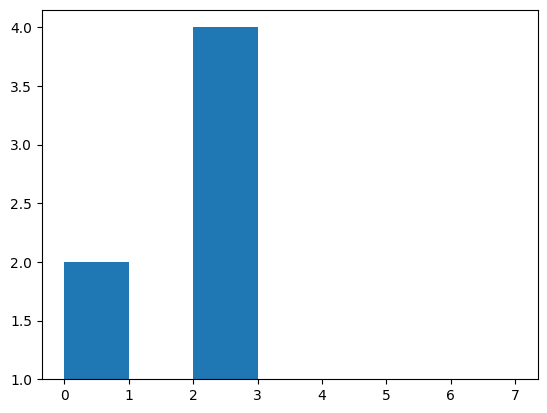

In [86]:
import matplotlib.pyplot as plt
plt.stairs([1,2,4,1,1,1,1], baseline=[2,2,1,1,1,1,1], fill=True)